Make a chart showing the running total of fatality crashes by year. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS
from datetime import datetime
import pytz
import inflect
p = inflect.engine()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

from crash_data_analysis import CrashDataAnalysis

In [2]:
# %%time
cda = CrashDataAnalysis()
df = cda.crash_dataframe(verbose=True)

Reading file: data/denver_crashes_2022_08_08__10_31.csv
Max timestamp: Fri Aug 5, 10:07 PM (2.52 days ago)
Fatality crashes this year: 51


In [3]:
# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=df
    , values='fatality'
    # , values='sbi_or_fatality'
    # , values='one'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=None
    )

running_total_crashes = crashes_by_day_of_year.cumsum()

this_year = datetime.now(tz=pytz.timezone('America/Denver')).year
max_day_of_year = df.reported_date.max().day_of_year

In [4]:
# Determine the number of days in each year. 365 normally, 366 for leap years

days_in_year = pd.Series(index=sorted(df.crash_year.unique()), dtype=int)

for year in sorted(df.crash_year.unique()):
    
    if year == this_year:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

In [5]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

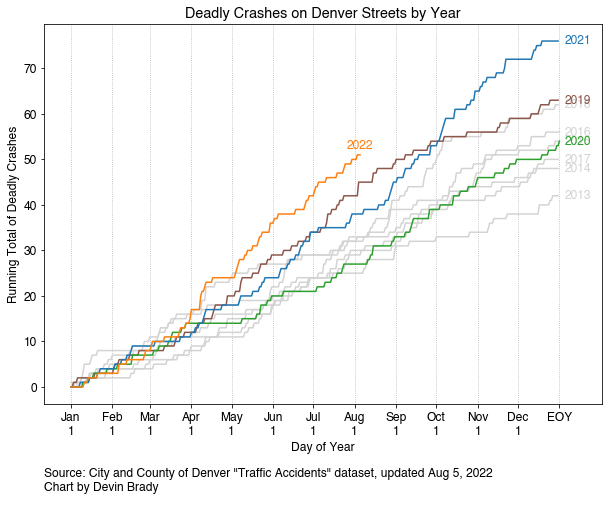

In [6]:
# Make the chart

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

for year in sorted(df.crash_year.unique()):
    if year == 2019:
        color = 'tab:brown'
    elif year == 2020:
        color = 'tab:green'
    elif year == 2021:
        color = 'tab:blue'
    elif year == 2022:
        color = 'tab:orange'
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
    # plt.plot([0, days_in_year[year]], [0, fatality_crashes_by_year[year]], color=color, linestyle=':')
    
    if year == this_year:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {df.reported_date.max().strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Deadly Crashes')
plt.title('Deadly Crashes on Denver Streets by Year')
_ = plt.savefig(
    'images/deadly_crashes_running_total.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [7]:
fatality_crashes_by_year = df.groupby('crash_year').fatality.sum()
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    51
Name: fatality, dtype: int64

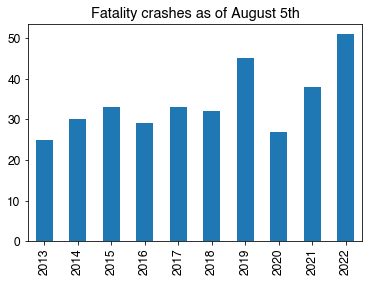

In [8]:
# Fatality crashes as of this day in the year
running_total_crashes.loc[max_day_of_year].plot(kind='bar')

date_string = df.reported_date.max().strftime('%B ')
date_string += p.ordinal(df.reported_date.max().strftime('%-d'))

plt.title(f"Fatality crashes as of {date_string}")

_ = plt.xlabel('')

In [9]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.254902
dtype: float64

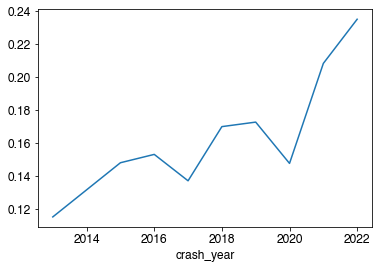

In [10]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year
_ = fatality_crash_per_day.plot()

In [11]:
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    51
Name: fatality, dtype: int64

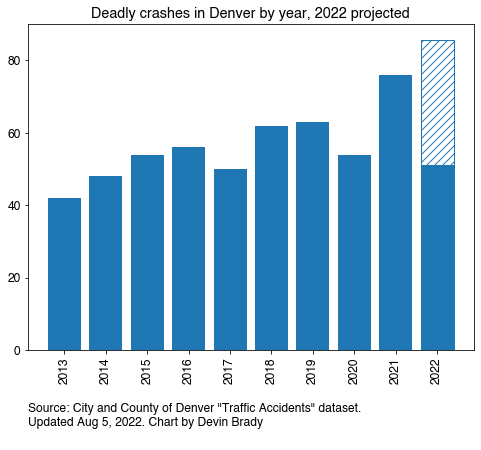

In [12]:
# Fatality crashes per year, current year projected
projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
this_year = df.reported_date.max().year
projected_fatality_crashes_by_year[this_year] = (
    fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(
    x=this_year
    , height=projected_fatality_crashes_by_year[this_year]
    , hatch='///'
    , fill=False
    , edgecolor=TABLEAU_COLORS['tab:blue']
)
ax.bar(x=fatality_crashes_by_year.index, height=fatality_crashes_by_year, color=TABLEAU_COLORS['tab:blue'])
ax.set_xticks(fatality_crashes_by_year.index, fontcolor='white')
# ax.tick_params(axis='x' ,direction='in', pad=-50, rotation=90, colors='white', labelsize=16)
# ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', rotation=90) 
plt.title('Deadly crashes in Denver by year, 2022 projected')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset.
Updated {df.reported_date.max().strftime('%b %-d, %Y')}. Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')

_ = plt.savefig('images/deadly_crashes_barplot.png', transparent=False, facecolor='white', bbox_inches='tight')

In [13]:
projected_fatality_crashes_by_year

crash_year
2013    42.00000
2014    48.00000
2015    54.00000
2016    56.00000
2017    50.00000
2018    62.00000
2019    63.00000
2020    54.00000
2021    76.00000
2022    85.78341
Name: fatality, dtype: float64

## Lists

In [14]:
f = cda.recent_fatality_crashes(df)

                 incident_address              neighborhood_id       crash_time_str  days_between  days_ago
       E 13TH AVE / N BROADWAY ST                 Civic Center  Sat May 21, 7:10 AM      3.392361 79.140253
       N CHAMBERS RD / E 40TH AVE                    Montbello  Sun May 22, 4:13 AM      0.877083 78.263170
      E HARVARD AVE / S QUEBEC ST                          NaN  Tue May 24, 7:17 PM      2.627778 75.635392
     E 46TH AVE / N BRIGHTON BLVD               Elyria Swansea  Mon May 30, 2:45 AM      5.311111 70.324281
                 I70 WB / I225 NB                          NaN  Mon May 30, 4:38 AM      0.078472 70.245809
   19601 BLOCK PENA BLVD OUTBOUND                          DIA   Thu Jun 2, 7:37 PM      3.624306 66.621503
    6400 BLOCK PENA BLVD OUTBOUND                          DIA   Sun Jun 5, 3:48 AM      2.340972 64.280531
       1500 BLOCK N COLORADO BLVD              South Park Hill Sat Jun 18, 12:30 AM     12.862500 51.418031
             N FOX ST / W 6T

## Crashes on streets where traffic calming was removed

Traffic-calming jersey barriers were removed from E 16th Ave around Monday, June 8, 2022. Source: Devin's photos 

Through traffic was restored to E 17th Ave on Tuesday, June 9, 2022. [Source](https://www.denvergov.org/Government/Agencies-Departments-Offices/Agencies-Departments-Offices-Directory/Department-of-Transportation-and-Infrastructure/Programs-Services/Projects/16th-Ave-Storm#:~:text=We%20do%20anticipate%20increased%20traffic,in%20place%20until%20March%202022.)

In [15]:
longitude_york = -104.95978236506068
longitude_colorado = -104.94071722366886

In [16]:
df.loc[
    (df.incident_address.str.contains('E 16TH AVE'))
    & (df.geo_lon < longitude_york)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
211617,E 16TH AVE / N WASHINGTON ST,"Thu Apr 28, 7:00 PM",TRAF - ACCIDENT - HIT & RUN
211953,E 16TH AVE / N DOWNING ST,"Fri May 27, 8:57 AM",TRAF - ACCIDENT - SBI
211247,PARK AVE / E 16TH AVE,"Mon May 30, 11:36 AM",TRAF - ACCIDENT
206246,N PEARL ST / E 16TH AVE,"Wed Jun 8, 12:18 PM",TRAF - ACCIDENT - HIT & RUN
211629,PARK AVE / E 16TH AVE,"Fri Jun 17, 10:27 PM",TRAF - ACCIDENT - HIT & RUN
214865,PARK AVE / E 16TH AVE,"Fri Jun 24, 11:36 AM",TRAF - ACCIDENT
210235,E 16TH AVE / N PEARL WASHINGTON ALY,"Sun Jun 26, 10:47 AM",TRAF - ACCIDENT - HIT & RUN
205876,E 16TH AVE / N OGDEN ST,"Mon Jun 27, 10:06 PM",TRAF - ACCIDENT
210241,E 16TH AVE / N LINCOLN ST,"Sun Jul 3, 12:32 PM",TRAF - ACCIDENT
212672,N LINCOLN ST / E 16TH AVE,"Thu Jul 7, 7:57 PM",TRAF - ACCIDENT


In [17]:
df.loc[
    (df.incident_address.str.contains('E 17TH AVE'))
    & (df.geo_lon > longitude_york)
    & (df.geo_lon < longitude_colorado)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
90600,3800 BLOCK E 17TH AVE,"Mon Jul 12, 7:04 AM",TRAF - ACCIDENT - HIT & RUN
1612,E 17TH AVE / N DETROIT ST,"Fri Aug 20, 5:52 PM",TRAF - ACCIDENT - POLICE
203253,E 17TH AVE / N MADISON MONROE ALY,"Thu Sep 30, 1:00 PM",TRAF - ACCIDENT
202733,N DETROIT ST / E 17TH AVE,"Wed Oct 6, 6:14 PM",TRAF - ACCIDENT - HIT & RUN
206688,E 17TH AVE / N COOK ST,"Mon Mar 14, 9:30 AM",TRAF - ACCIDENT
211215,N GARFIELD ST / E 17TH AVE,"Fri Apr 1, 8:31 PM",TRAF - ACCIDENT
210587,E 17TH AVE / N JOSEPHINE ST,"Tue Jun 14, 12:10 PM",TRAF - ACCIDENT
207816,2900 BLOCK E 17TH AVE,"Thu Jun 23, 11:25 AM",TRAF - ACCIDENT - HIT & RUN
214593,3600 BLOCK E 17TH AVE,"Sun Jun 26, 1:49 AM",TRAF - ACCIDENT - DUI/DUID
275,3628 E 17TH AVE,"Sun Jun 26, 3:10 AM",TRAF - ACCIDENT
